[View in Colaboratory](https://colab.research.google.com/github/suzanaporto/DRScan_versao1/blob/master/DRSCAN.ipynb)

#DRSCAN

In [0]:
#Insert snp

snp_id = 'rs268' #@param {type:"string"}
snp_id = snp_id[2:]
  


##Initialize

In [6]:
#install excelwriter
!pip install XlsxWriter
#install bedtool
!pip3 install pybedtools
#install git project
!git clone https://github.com/suzanaporto/DRSCAN_sequence
#change directory
%cd ./DRSCAN_sequence/DRSCAN_sequence
#install fimo


Cloning into 'DRSCAN_sequence'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 24 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.
/content/DRSCAN_sequence/DRSCAN_sequence/DRSCAN_sequence/DRSCAN_sequence


##Get snp information

In [0]:
#get parameters by snp name
#request by url
import requests, sys

def request_info_by_id(snp_id):
  
  server = "https://api.ncbi.nlm.nih.gov/variation/v0/beta/refsnp/"

  r = requests.get(server+snp_id, headers={ "Content-Type" : "application/json"})

  if not r.ok:
    r.raise_for_status()
    sys.exit()

  decoded = r.json()
  
  return decoded

In [0]:
#using method to parse all snp information from ncbi
res_json = request_info_by_id(snp_id)

In [15]:
#method to get the right information from json result
import numpy as np

def parse_json(res_json):
  #get num of genomic placements (versions)
  num_genomic_placements = len(res_json['primary_snapshot_data']['placements_with_allele'])  
    
  # sometimes there is empty fields in the genomic placements... Detect and remove them! 
  temp_assertion = np.array([res_json['primary_snapshot_data']['placements_with_allele'][idx]['placement_annot']['seq_id_traits_by_assembly'] for idx in range(num_genomic_placements)])
  ban_idexs = np.array([len(x)!=0 for x in temp_assertion])
  temp_assertion = temp_assertion[ban_idexs]

  # Get the genomic placements (versions) names
  gnenome_versions = [ x[0]["assembly_name"] for x in temp_assertion]
  print(gnenome_versions)
  
  # get the number of variations
  allele_variations = len([res_json['primary_snapshot_data']['placements_with_allele'][idx]['alleles'] for idx in range(1)][0])

  # get the snps idexes
  snp_idxs = np.array([[res_json['primary_snapshot_data']['placements_with_allele'][x]['alleles'][y]['hgvs'] for y in range(allele_variations)][1:] for x in range(num_genomic_placements)])

  # remove those without valid genomic placements (versions) names 
  snp_idxs = snp_idxs[ban_idexs].tolist()

  return {"gnenome_versions": gnenome_versions, "snp_idxs_list": snp_idxs}

snp_info = parse_json(res_json)

[u'GRCh38.p7', u'GRCh37.p13']


In [0]:
#snp information into dataframe
import pandas as pd
df = pd.DataFrame(snp_info)

In [0]:
#using regular expressions to format snp information
#into dictionary
import re

def snp_info_input(snp_id):
  
  #examples
  #l = re.compile("(?<!^)\s+(?=[A-Z])(?!.\s)").split(s)
  #j = re.compile("[^(\d)\w+]").split(snp_id)
  
  base = re.compile("[^(\d)\w+]").split(snp_id)[3]
  base_chrom = re.compile("[^(\d)\w+]").split(snp_id)[0]
  
  #  print (base)
  dict = {
      "chrom" : re.compile("(\d+).0").split(base_chrom)[2],
      "location" : re.compile("[^(\d)]").split(base)[0],
      "allele_wt" : re.compile("[(\d)]").split(base)[-1],
      "allele_v": re.compile("[^(\d)\w+]").split(snp_id)[4],
  }
  
  return dict

In [0]:
#getting genome versions into dataframe
gn_version = []

for snp_idx_list in df['snp_idxs_list']:
  res = []
  for snp_idx in snp_idx_list:
    res.append(snp_info_input(snp_idx))  
  gn_version.append(res)
  
df['snp_info_dict'] = gn_version  

In [0]:
#getting the information from dict
x = df.loc[0,"snp_info_dict"]
snp_dict = x[0]
snp_location = snp_dict['location']
snp_chrom = snp_dict['chrom']
snp_al = snp_dict['allele_wt']
snp_al_v = snp_dict['allele_v']

##Sequences Program

In [20]:
#run sequence program
print(snp_name)
!python3 main3.py --snp_name "$snp_name" --snp_chrom "$snp_chrom" --snp_location "$snp_location" --snp_al_wt "$snp_al" --snp_al_v "$snp_al_v"

rs268
nome: rs268
local: 19956018
cromossomo: 8
alelo ancestral: A
alelo ancestral posição: 0
minor allele: G
posição minor allele: 0
nome: rs268
local19956018
8
A
0
G
0
>sequence_wild_type|rs268|8|A|51
CTGCTTGAGTTGTAGAAAGAACCGCTGCAACAATCTGGGCTATGAGATCAATAAAGTCAGAGCCAAAAGAAGCAGCAAAATGTACCTGAAGACTCGTTCTC
>sequence_variation|rs268|8|G|51
CTGCTTGAGTTGTAGAAAGAACCGCTGCAACAATCTGGGCTATGAGATCAGTAAAGTCAGAGCCAAAAGAAGCAGCAAAATGTACCTGAAGACTCGTTCTC


In [21]:
#downloading and cofiguring fimo
!wget http://meme-suite.org/meme-software/5.0.2/meme-5.0.2.tar.gz
!tar xvf meme-5.0.2.tar.gz
%cd meme-5.0.2
! ./configure --prefix=$HOME/meme --with-url=http://meme-suite.org/ --enable-build-libxml2 --enable-build-libxslt
!make
!make test
!make install
%cd 
%cd meme/bin


Redirecting output to ‘wget-log’.
meme-5.0.2/
meme-5.0.2/aclocal.m4
meme-5.0.2/ARCHIVE_DATE
meme-5.0.2/ARCHIVE_REVISION
meme-5.0.2/AUTHORS
meme-5.0.2/build.xml.in
meme-5.0.2/ChangeLog
meme-5.0.2/config/
meme-5.0.2/config.h.in
meme-5.0.2/configure
meme-5.0.2/configure.ac
meme-5.0.2/COPYING
meme-5.0.2/doc/
meme-5.0.2/etc/
meme-5.0.2/INSTALL
meme-5.0.2/m4/
meme-5.0.2/Makefile.am
meme-5.0.2/Makefile.in
meme-5.0.2/MemeSuite.properties.in
meme-5.0.2/NEWS
meme-5.0.2/README
meme-5.0.2/scripts/
meme-5.0.2/src/
meme-5.0.2/tests/
meme-5.0.2/website/
meme-5.0.2/website.mk
meme-5.0.2/website/canvas-test.html
meme-5.0.2/website/css/
meme-5.0.2/website/images/
meme-5.0.2/website/index.html
meme-5.0.2/website/js/
meme-5.0.2/website/lib/
meme-5.0.2/website/Makefile.am
meme-5.0.2/website/Makefile.in
meme-5.0.2/website/src/
meme-5.0.2/website/templates/
meme-5.0.2/website/web.xml
meme-5.0.2/website/templates/ame.tmpl
meme-5.0.2/website/templates/ame_verify.tmpl
meme-5.0.2/website/templates/centrimo.tmpl

##FIMO

In [64]:
#upload motif
from google.colab import files
uploaded = files.upload()

Saving sequenciasdef.fna to sequenciasdef.fna


In [60]:
#correct directory/move generated sequence to correct directory
%cd meme/bin

/root/meme/bin


In [65]:
#runnning fimo
! ./fimo JASPAR2018_CORE_vertebrates_non-redundant.meme sequenciasdef.fna

Using motif +MA0004.1 of width 6.
Using motif -MA0004.1 of width 6.
Computing q-values.
Using motif +MA0006.1 of width 6.
Using motif -MA0006.1 of width 6.
Computing q-values.
Using motif +MA0019.1 of width 12.
Using motif -MA0019.1 of width 12.
Computing q-values.
Estimating pi_0 from a uniformly sampled set of 3600 p-values.
Estimating pi_0.
Estimated pi_0=0.948378
Using motif +MA0025.1 of width 11.
Using motif -MA0025.1 of width 11.
Computing q-values.
Using motif +MA0029.1 of width 14.
Using motif -MA0029.1 of width 14.
Computing q-values.
Using motif +MA0030.1 of width 14.
Using motif -MA0030.1 of width 14.
Computing q-values.
Using motif +MA0031.1 of width 8.
Using motif -MA0031.1 of width 8.
Computing q-values.
Using motif +MA0038.1 of width 10.
Using motif -MA0038.1 of width 10.
Computing q-values.
Estimating pi_0 from a uniformly sampled set of 3680 p-values.
Estimating pi_0.
Estimated pi_0=1
Using motif +MA0040.1 of width 11.
Using motif -MA0040.1 of width 11.
Computing q-val

In [75]:
%cd fimo_out

/root/meme/bin/fimo_out


##Filter DataFrame

In [0]:
#filter dataframe
import pandas as pd

#df_fimo_output = pd.read_csv('fimo_out.tsv', sep='\t') 

In [0]:
def row_out_of_range_single(seq_start,seq_stop,seq_name,idx):
        
  relative_position =  int(seq_name.split('|')[4])
  condition_3 = relative_position < seq_start 
  condition_2 = relative_position > seq_stop
  #index list
  index_list = []

  if  (condition_3 or condition_2) :
    return idx
  else:
    return None

In [0]:
def filter_range(table_output):
  #table into data frame
  df_fimo_output = pd.read_csv(table_output, sep='\t')
  df_fimo_output = df_fimo_output.dropna()
  #start values into array
  array_start = df_fimo_output['start'].values
  #stop values into array
  array_stop = df_fimo_output['stop'].values
  #sequence name values
  array_sequence_name = df_fimo_output['sequence_name'].values
  #index list
  index_list = []
  
  #with pd.option_context('display.max_rows', 100, 'display.max_columns', 100):
  #  display(df_fimo_output)
  
  for idx, (seq_start,seq_stop,seq_name) in enumerate( zip(array_start, array_stop, array_sequence_name) ):
    
    seq_type = seq_name.split('|')[0]
    condition_1 = seq_type == 'sequence_variation'
    condition_2 = seq_type == 'sequence_wild_type'
    condition_3 = seq_type == 'sequence_combinations'
    
    #first filter is out_of_range filter
    if (condition_1 or condition_2):
      index = row_out_of_range_single(seq_start,seq_stop,seq_name,idx)
      if (not(index == None)):
        index_list.append(index)
    if (condition_3):
      index = row_out_of_range_multiple(seq_start,seq_stop,seq_name,idx)
      if (not(index == None)):
        index_list.append(index)
      
  #print (str(index_list))
  print ("Tamanho da lista: " + str(len(index_list)))
  #print ("-------------------------Testando----------------------------")
  #filter by id
  #new_df = df_fimo_output.drop(df_fimo_output.index[index_list],axis=0)
  idx_list_selected = [ i for i in range(len(df_fimo_output)) if not i in index_list ]
  
  new_df = df_fimo_output.iloc[idx_list_selected]
  
  return new_df
  

In [0]:
def filter_dataframe(table_output, log=False):
  
  new_df = filter_range(table_output)
  
  print ("Tamanho linha: ", len(new_df))  
  #display(new_df)
  
  #display sorted motifs
  #display (new_df.sort_values(['motif_alt_id','start']))
  #display (new_df)
  
  #start values(new_df) into array
  array_start = new_df['start'].values
  #stop values(new_df) into array
  array_stop = new_df['stop'].values
  #sequence name(new_df) values
  array_sequence_name = new_df['sequence_name'].values
  #array motifs
  array_motifs = new_df['motif_alt_id'].values
  
  #iterate through entire list/need treatment for combinations
  for idx, (seq_start,seq_stop,seq_name,motif) in enumerate( zip(array_start, array_stop, array_sequence_name, array_motifs) ):
      #current variables
      current_index = idx
      verify_index = False
      current_motif = motif
      current_seq_name = seq_name
      current_start = seq_start
      current_stop = seq_stop
      
      seq_type = seq_name.split('|')[0]
      condition_1 = seq_type == 'sequence_variation'
      condition_2 = seq_type == 'sequence_wild_type'
      condition_3 = seq_type == 'sequence_combinations'
      
      if condition_1 or condition_2:
        for idx, (seq_start,seq_stop,seq_name,motif) in enumerate( zip(array_start, array_stop, array_sequence_name, array_motifs) ):
          snp_name = seq_name.split('|')[1]
          #compare list with current values
          condition_m = current_motif == motif
          condition_sn = current_seq_name.split('|')[0] != seq_name.split('|')[0]
          condition_sn2 = current_seq_name.split('|')[1] == seq_name.split('|')[1]
          condition_csta = current_start == seq_start
          condition_csta1 = seq_start == range(int(current_start-50),int(current_start))
          condition_csto = current_stop == seq_stop
          condition_csto1 = seq_stop == range(int(current_stop),int(current_stop + 50))
        
          if condition_m and condition_sn and condition_sn2 and (condition_csta or condition_csta1).any and (condition_csto or condition_csto1).any:
            #new data frame droping all occurences of specified TF-snp pair
            new_df = new_df.drop(new_df[(new_df.motif_alt_id == motif) & (new_df.sequence_name.str.contains(snp_name))].index)
            
      #missing tests/half completed/reset variables after processing    
      if condition_3:
        count = 0
        #get number of all snps in combinations sequence
        for i in current_seq_name.split('|'):
          if i[:2] == 'rs':
            count = count + 1
        total = count
        print (total)
        #snp list
        snp_list = current_seq_name.split('|')[1:total+1]
        #allele list
        allele_list = []
        #for i in range(len(current_seq_name.split('|')[total+1:]))
        #  if !(current_seq_name.split('|')[i].isDigit):
        #    allele_list.add(current_seq_name.split('|')[i])
        #allele_list = current_seq_name.split('|')[total+1:]
        size_in_list = len(snp_in_list)
        allele_list = current_seq_name.split('|')[total+1:((total+1)+size_in_list)+1]
        #get positions
        position_in_list = pos_in_TF(current_start,current_stop)
        snp_in_list = snp_in_TF(current_start,current_stop)
        
        for idx, (seq_start,seq_stop,seq_name,motif) in enumerate( zip(array_start, array_stop, array_sequence_name, array_motifs) ):
          
          condition_m = current_motif == motif
          condition_sn2 = snp_list == seq_name.split('|')[1:total]
          #range search needs maintain in snp start stop in snp range.
          condition_csta = current_start == seq_start
          condition_csto = current_stop == seq_stop
          condition_al_dif = allele_list != seq_name.split('|')[total+1:((total+1)+size_in_list)+1]
        
          if condition_m and condition_sn2 and condition_csta and condition_csto and condition_al_dif:
            #new data frame droping all occurences of specified TF-snps pair
            new_df = new_df.drop(new_df[(new_df.motif_alt_id == motif) & (new_df.sequence_name.str.contains(snp_list))].index)
          
  display (new_df.sort_values(['motif_alt_id','start']))
  print ("Tamanho DataFrame: ",len(new_df))
  return new_df

In [0]:
def count_snps (filtered_dataframe):
  subtotals = filtered_dataframe.groupby(filtered_dataframe['sequence_name'].str.split('|').str[1]).count()
  total = subtotals.drop(columns=['sequence_name', 'motif_alt_id','start', 
                                  'stop','strand','score','p-value','q-value',
                                  'matched_sequence'])
  total = total.reset_index().rename(index=str, 
                                     columns={'sequence_name': "SNP NAME", 
                                              "motif_id": "COUNT"})
  display(total)
  total.plot.bar(x='SNP NAME', y='COUNT',rot=0) 

##Output

Tamanho da lista: 384
('Tamanho linha: ', 52)


,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
145,MA0471.1,E2F6,sequence_variation|rs439401|19|C|51,51.0,61.0,-,12.89660,2.930000e-05,0.049200,GGGTGGGAGGG
194,MA0471.1,E2F6,sequence_wild_type|rs439401|19|T|51,51.0,61.0,-,12.37930,4.010000e-05,0.049200,GGGTGGGAGGA
95,MA0154.3,EBF1,sequence_wild_type|rs8103315|19|C|51,47.0,60.0,-,12.39340,1.730000e-05,0.035500,GGACCCCAGGGACT
110,MA0154.3,EBF1,sequence_wild_type|rs8103315|19|C|51,47.0,60.0,+,11.85250,2.200000e-05,0.035500,AGTCCCTGGGGTCC
322,MA0732.1,EGR3,sequence_variation|rs439401|19|C|51,50.0,64.0,+,6.36207,6.800000e-05,0.049000,CCCCTCCCACCCCCT
336,MA0732.1,EGR3,sequence_wild_type|rs439401|19|T|51,50.0,64.0,+,6.22414,7.100000e-05,0.049000,CTCCTCCCACCCCCT
75,MA0733.1,EGR4,sequence_wild_type|rs439401|19|T|51,50.0,65.0,+,13.14550,1.300000e-05,0.017900,CTCCTCCCACCCCCTC
76,MA0733.1,EGR4,sequence_variation|rs439401|19|C|51,50.0,65.0,+,13.07270,1.360000e-05,0.017900,CCCCTCCCACCCCCTC
345,MA0149.1,EWSR1-FLI1,sequence_variation|rs439401|19|C|51,43.0,60.0,-,-14.81580,7.190000e-05,0.030000,GGTGGGAGGGGAAGAGAG
148,MA0092.1,Hand1::Tcf3,sequence_variation|rs405509|19|G|51,45.0,54.0,+,12.13480,2.980000e-05,0.108000,TGTCTGGATT


,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
95,MA0154.3,EBF1,sequence_wild_type|rs8103315|19|C|51,47.0,60.0,-,12.39340,0.000017,0.03550,GGACCCCAGGGACT
110,MA0154.3,EBF1,sequence_wild_type|rs8103315|19|C|51,47.0,60.0,+,11.85250,0.000022,0.03550,AGTCCCTGGGGTCC
345,MA0149.1,EWSR1-FLI1,sequence_variation|rs439401|19|C|51,43.0,60.0,-,-14.81580,0.000072,0.03000,GGTGGGAGGGGAAGAGAG
148,MA0092.1,Hand1::Tcf3,sequence_variation|rs405509|19|G|51,45.0,54.0,+,12.13480,0.000030,0.10800,TGTCTGGATT
106,MA0155.1,INSM1,sequence_wild_type|rs8100239|19|T|51,51.0,62.0,+,12.76530,0.000021,0.07060,TTTCAGGGGTCT
233,MA0741.1,KLF16,sequence_variation|rs439401|19|C|51,49.0,59.0,+,11.20690,0.000047,0.04070,TCCCCTCCCAC
105,MA0599.1,KLF5,sequence_variation|rs439401|19|C|51,49.0,58.0,+,13.46940,0.000021,0.02980,TCCCCTCCCA
381,MA0599.1,KLF5,sequence_variation|rs2075650|19|G|51,49.0,58.0,-,10.79590,0.000086,0.03370,ACTCCACCCC
314,MA0863.1,MTF1,sequence_wild_type|rs8103315|19|C|51,38.0,51.0,+,6.50000,0.000064,0.21200,TCTGCAGACAGTCC
138,MA0057.1,MZF1(var.2),sequence_variation|rs439401|19|C|51,47.0,56.0,-,12.01010,0.000028,0.05990,GGAGGGGAAG


('Tamanho DataFrame: ', 24)


,SNP NAME,COUNT
0,rs157580,3
1,rs1871047,1
2,rs2075650,3
3,rs405509,2
4,rs439401,9
5,rs8100239,3
6,rs8103315,3


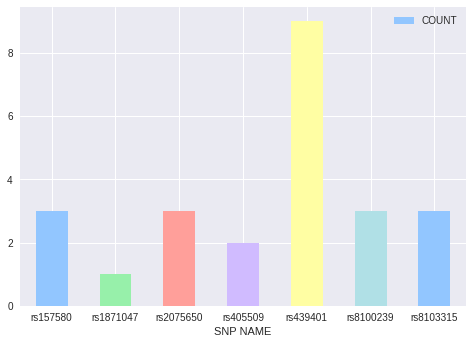

In [83]:
#show dataframe and snp_count
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
f_dataframe = filter_dataframe ('fimo.tsv',True)
count_snps(f_dataframe)

##Download Excel

In [0]:
writer = pd.ExcelWriter('output.xlsx', engine='xlsxwriter')

f_dataframe.to_excel(writer, index=False, sheet_name='report')

workbook = writer.book

worksheet = writer.sheets['report']

writer.save()

In [0]:
from google.colab import files

files.download('output.xlsx')